In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from NeedALight.magnus import Magnus1CW_data, Magnus3CW_data_Re, Magnus3CW_data_Im, Magnus1CW_fit, Magnus3CW_fit_Re, Magnus3CW_fit_Im


We begin by reading the data from given files. Data should be in a 3 column list, separated by commas, where: 
- 1st column: Wavelength in nm.
- 2nd column: Ordinary index of refraction.
- 3rd column: Extra-Ordinary index of refraction.

The following analysis is for a Continous Wave Pump.

In [3]:
with open('refractive_indices_bulk.txt', 'r') as f:
    l = [[float(num) for num in line.split(',')] for line in f]


We choose to work in nanometers and terahertz. If one wants to change that, multiply "c" (speed of light) and "wl" (wavelength) accordingly. In the following cell, we specify both average Pump and Signal wavelengths of interest, their corresponding wavevector, and define both Ordinary and Extra-Ordinary frequencies as a function of wavelength.

In [4]:
Mat = np.asarray(l)
#Modifying speed of light s.t. we are in nm/thz.
c=3*10**8 * 10**9 * 10**(-12)
#Separating data.
wl = Mat[:,0]
Ord_ref = Mat[:,1]
Ext_ref = Mat[:,2]


#We first specify the pump and signal wavelengths of interest and length of crystal
L = 2.5*10**(6) #might need to choose something lower than the actual experimental value. Here we choose 2.5 mm expressed in nm. 
p_wl=514
s_wl=825

#Frequency given wavelength
omega = 2*np.pi*c/wl

#Ordinary and Extra-ordinary wavevectors
k_ord = 2*np.pi*Ord_ref/wl
k_ext = 2*np.pi*Ext_ref/wl

Next we define several different interpolating functions so that we can have some approximative access to values in between the data set. This way, given an average signal and pump wavelength, we can always obtain the corresponding average idler wavelength which conserves energy (could possibly not be part of the data set).

In [5]:
#Defining the different interpolation functions to allow for points to lie in between the data points.
no = lambda x: np.interp(x,wl,Ord_ref) #given a specific wavelength, outputs corresponding Ordinary index 
ne = lambda x: np.interp(x,wl,Ext_ref) #given a specific wavelength, outputs corresponding Extra-Ordinary index 

w_wl = lambda x: np.interp(x,wl,omega) #given a wavelength, outputs corresponding frequency

wl_w = lambda x: np.interp(x,np.flip(omega),np.flip(wl)) #given a frequency, outputs corresponding wavelength

k_o_wl =  lambda x: np.interp(x,wl,k_ord) #given specific wavelength, outputs corresponding ordinary wavevector
k_e_wl =  lambda x: np.interp(x,wl,k_ext) #given specific wavelength, outputs corresponding extra-ordinary wavevector

#The x coordinate needs to be an increasing function, hence why we use flips in the following
k_o =  lambda x: np.interp(x,np.flip(omega),np.flip(k_ord)) #given specific frequency, outputs corresponding Ordinary wavevector
k_e = lambda x: np.interp(x,np.flip(omega),np.flip(k_ext)) #given specific frequency, outputs corresponding Extra-Ordinary wavevector

Given the chosen average Pump and Signal wavelengths, we find the corresponding Idler wavelength which conserves Energy ($\omega_p=\omega_s+\omega_i$). We then find the corresponding average Idler wavevector and the corresponding poling wavevector (k_pol) required to conserve momentum. We output the corresponding average Idler wavelength and the poling period in microns.

In [6]:
#Given chosen pump and signal wavelength, find corresponding wavelength for idler which conserves energy.

ws_avg = w_wl(s_wl)
wp_avg = w_wl(p_wl)
wi_avg = wp_avg-ws_avg
i_wl = wl_w(wi_avg)

p_k = k_o_wl(p_wl) #pump wavevector

k_pol = p_k - k_o_wl(s_wl) - k_e_wl(i_wl)
period = 2*np.pi / k_pol

#Outputs corresponding idler wavelength in nanometers and poling period in micrometers.
print(i_wl, period*10**(-3))

1363.5048276916773 65.82284927504581


Consequently, one could also want to work with a given poling period and pump wavelength. In this next cell, we solve for the central signal and idler wavelenghts that give rise to quasi-phase-matching and energy conservation.

In [7]:
#Specify the poling period in nm
pol_period = 65.4*10**(3) #This is the value in microns converted into nm
k_pol = 2*np.pi/pol_period

def cons(x):
    """Given [signal_wl,idler_wl] evaluates both energy and momentum conservation"""
    return [1/(x[0])+1/(x[1])-1/(p_wl), 
            no(x[0])/x[0]+ne(x[1])/x[1]+1/pol_period-no(p_wl)/p_wl]
root = fsolve(cons,[825,1560]) #Depending on experimental results, change initial values for solver (i.e. what you expect [signal, idler] )
s_wl = root[0]
i_wl = root[0]

print(root)

[ 823.94836994 1366.38712517]


Make sure that both value are indeed in the list.

Make sure that the average Idler wavelength is well inside the data set. Having obtained the average Idler wavelength and required poling period. We can now plot the First Order Magnus term corresponding to the Joint Spectral Amplitude without any time ordering corrections. We plot the JSA as a function of Signal wavelength.

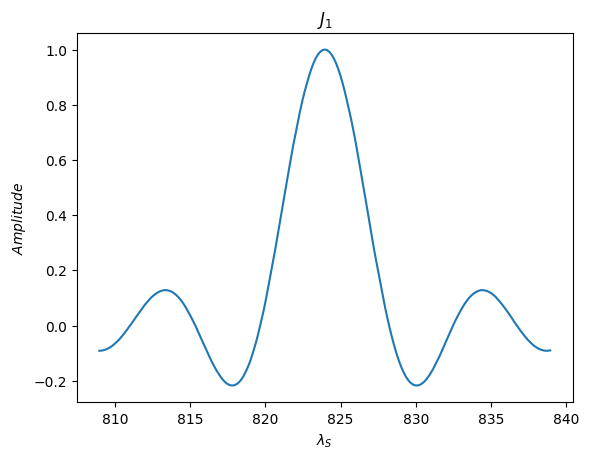

In [8]:
#Now suppose we want to probe over a range of wavelengths. Such that s_wl varies +/- 15 nm. 
N=201
wl_range = 15 
lambda_s = np.linspace(s_wl-wl_range, s_wl+wl_range, N)

ws = w_wl(lambda_s)
wi=wp_avg-ws


#First Order JSA, taken to be defined from x=-L/2 to x=L/2 
J1 = Magnus1CW_data(ws,wi,k_o,k_e,k_pol,p_k,L)

fig, ax1 = plt.subplots()
ax1.plot(lambda_s, J1) 
ax1.set_xlabel(r"$\lambda_{S}$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$J_{1}$")
plt.show()

We now consider the next leading order Magnus corrections. We do this in two different methods:
- First, we use the interpolating functions and use all the data-set given.
- Second, we find taylor expansions of k(\omega) around the average frequencies of interest and use said expansions rather than the whole data-set.

Both methods generate similar results (numerical errors).

The next leading order Magnus correction terms typically include Principal Value integrals which are taken from (-inf,inf). We can usually do these integrals with the Cubature package and a change of variables. This is what we do for the Second method where we extend the taylor expansions to +/-inf. However, with the finite data-set, we need to define functions such that if we are outside of the frequencies supported by the data then it returns 0.

We break down the third order Magnus corrections into 2 different terms: $J_3$ and $K_3$. When the phase-matching function is real, the contributions to the JSA from $J_3$ is purely real and $K_3$ is purely imaginary.

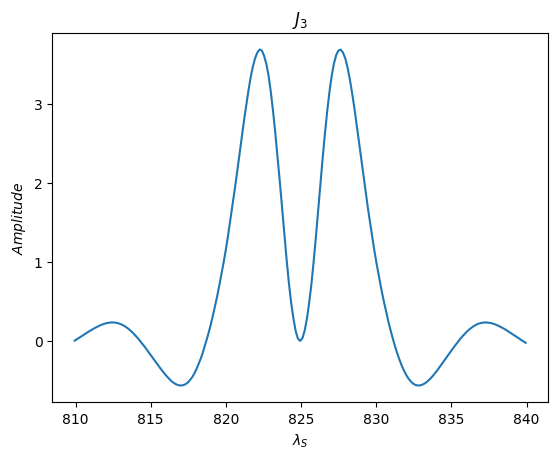

In [33]:
#J3 contributions to third order correction. Can take a couple minutes to run.
J3 = Magnus3CW_data_Re(omega,ws,wi,k_o,k_e,k_pol,p_k,L)

fig, ax1 = plt.subplots()
ax1.plot(lambda_s, J3) 
ax1.set_xlabel(r"$\lambda_{S}$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$J_{3}$")
plt.show()

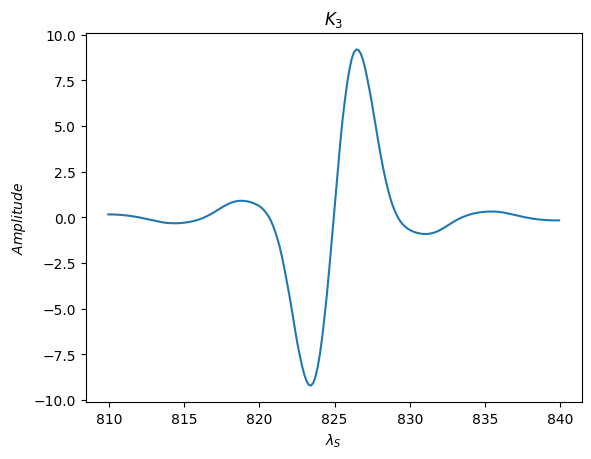

In [11]:
#K3 contribution to third order corrections
K3 = Magnus3CW_data_Im(omega,ws,wi,k_o,k_e,k_pol,p_k,L)

fig, ax1 = plt.subplots()
ax1.plot(lambda_s, K3) 
ax1.set_xlabel(r"$\lambda_{S}$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$K_{3}$")
plt.show()

We now combine all the corrections together with the proper coefficients to give us the corrected JSA. Note that everything was done for the case where x=-L/2 to x=L/2. However, in the corrections none of the phases depend on the variables of integration and as such all terms are proportional to the phases of first order contribution. So if one were to take the nonlinear region to be from x=0 to x=L, one simply needs to multiply the final product (or each term individually) by the proper phase ($exp[iL(k_s+k_i+k_{pol}-p_k)/2]$)

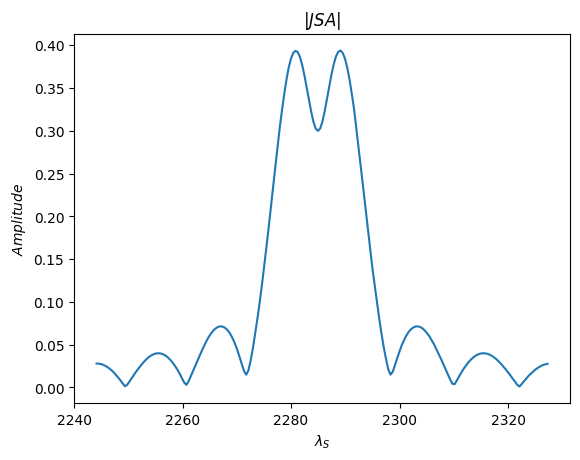

In [34]:
#Strength parameter for Magnus expansion
JSA_full = lambda epsilon: epsilon*J1+epsilon**3*(J3-1j*K3)

#Multiply by this phase if x0=0 is the start of the nonlinear region
Phase = np.exp(1j*L*(k_o(ws)+k_e(wi)+k_pol-p_k)/2) 


epsilon = 0.3
fig, ax1 = plt.subplots()
ax1.plot(ws, np.abs(JSA_full(epsilon)))
ax1.set_xlabel(r"$\lambda_{S}$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$|JSA|$")
plt.show()

Finaly we plot the ouput spectra for the signal. We normalize such that the max value is unity.

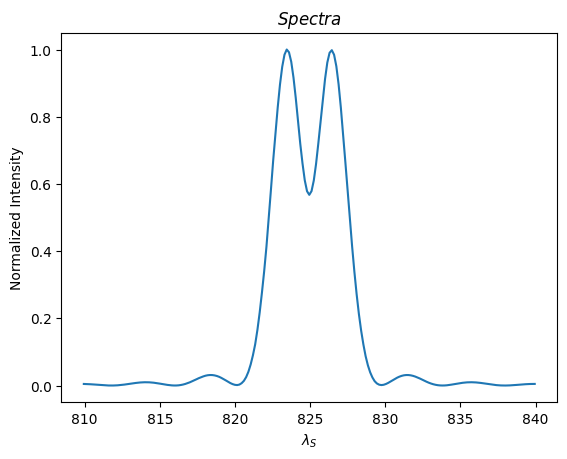

In [35]:
Intensity = lambda epsilon: np.sinh(np.abs(JSA_full(epsilon)))**2/np.amax(np.sinh(np.abs(JSA_full(epsilon)))**2)

fig, ax1 = plt.subplots()
ax1.plot(lambda_s, Intensity(epsilon))
ax1.set_xlabel(r"$\lambda_{S}$")
ax1.set_ylabel(r"Normalized Intensity")
ax1.set_title(r"$Spectra$")
plt.show()

And we can now compare the above functions for different levels of interaction strength.

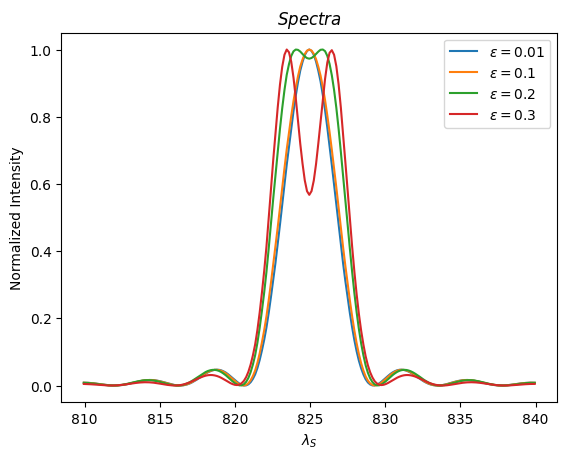

In [36]:
Intensity = lambda epsilon: np.sinh(np.abs(JSA_full(epsilon)))**2/np.amax(np.sinh(np.abs(JSA_full(epsilon)))**2)

fig, ax1 = plt.subplots()
ax1.plot(lambda_s, Intensity(0.01),label=r"$\epsilon=0.01$")
ax1.plot(lambda_s, Intensity(0.1),label=r"$\epsilon=0.1$")
ax1.plot(lambda_s, Intensity(0.2),label=r"$\epsilon=0.2$")
ax1.plot(lambda_s, Intensity(0.3),label=r"$\epsilon=0.3$")
ax1.set_xlabel(r"$\lambda_{S}$")
ax1.set_ylabel(r"Normalized Intensity")
ax1.set_title(r"$Spectra$")
ax1.legend()
plt.show()

Next we do all of the above, but by taylor expanding around the central frequencies. This makes some of the Magnus corrections evaluate faster than above.

In [37]:
#Given a range of signal wavelengths around a central wavelength, find the corresponding min/max frequency indices for the signal and idler.
s_min = np.argmin(np.abs(omega-ws[0]))
s_max = np.argmin(np.abs(omega-ws[-1]))
i_max = np.argmin(np.abs(omega-wi[0]))
i_min = np.argmin(np.abs(omega-wi[-1]))

#With the range of frequency identified, fit the data to polynomial of order 2(can change this if wanted)
s_var = np.polyfit(omega[s_min:s_max],k_ord[s_min:s_max],2)
i_var = np.polyfit(omega[i_min:i_max],k_ext[i_min:i_max],2)

#Construct polynomial functions
ks_poly = np.poly1d(s_var)
ki_poly = np.poly1d(i_var)

As a quick sanity check, we plot k(omega_s) from both the actual data and the expansion as well as their |diff| in the second cell.

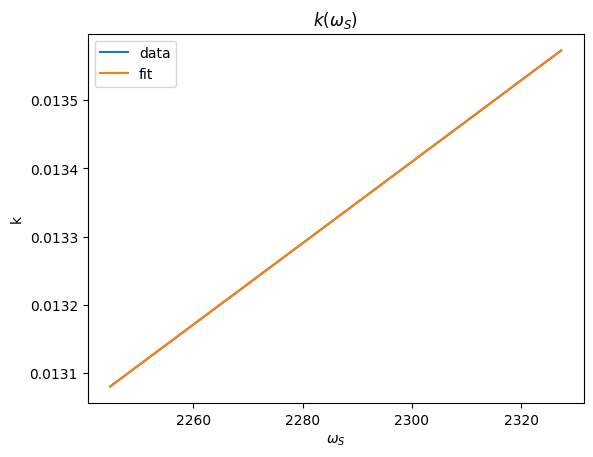

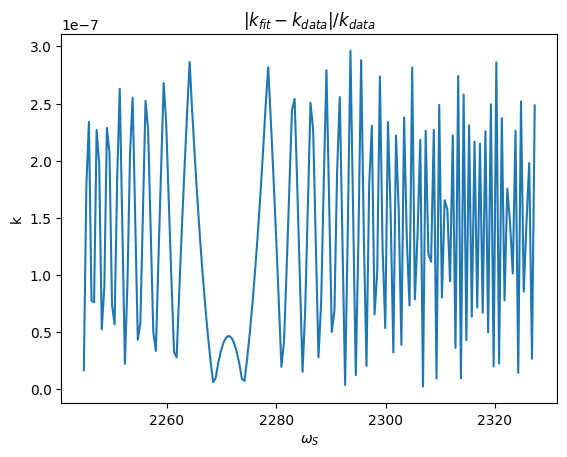

In [38]:
fig, ax1 = plt.subplots()
ax1.plot(omega[s_min:s_max], k_ord[s_min:s_max],label='data')
ax1.plot(omega[s_min:s_max], ks_poly(omega[s_min:s_max]),label='fit')
ax1.set_xlabel(r"$\omega_{S}$")
ax1.set_ylabel(r"k")
ax1.set_title(r"$k(\omega_{S})$")
ax1.legend()
plt.show()

fig, ax2 = plt.subplots()
ax2.plot(omega[s_min:s_max], np.abs(k_ord[s_min:s_max]-ks_poly(omega[s_min:s_max]))/k_ord[s_min:s_max])
ax2.set_xlabel(r"$\omega_{S}$")
ax2.set_ylabel(r"k")
ax2.set_title(r"$|k_{fit}-k_{data}|/k_{data}$")
plt.show()

We now evaluate the Magnus terms from our expansion polynomials. We choose the same range of frequencies as before.

First order term is simply the PMF with energy conservation.

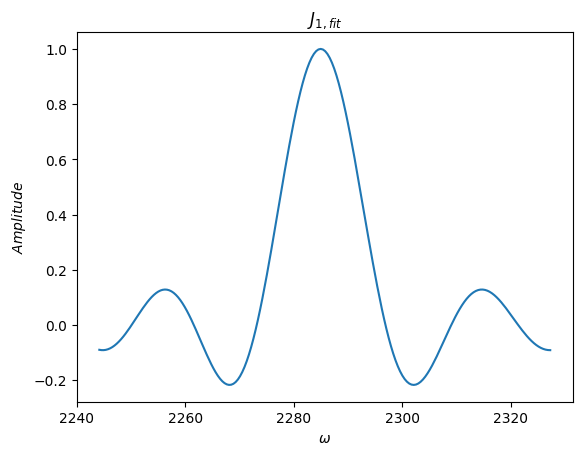

In [39]:
#First Order Magnus JSA
J1_fit = Magnus1CW_fit(ws,wi,ks_poly,ki_poly,k_pol,p_k,L)
fig, ax1 = plt.subplots()

ax1.plot(ws, J1_fit) 
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$J_{1,fit}$")
plt.show()

Again, we can easily compare to J1 calculated above using the full data-set. On the same graph they appear to be the same. Plotting the difference we see some difference but it is orders of magnitude smaller. This is the case for all subsequent Magnus terms and as such we do not include differences after this term.

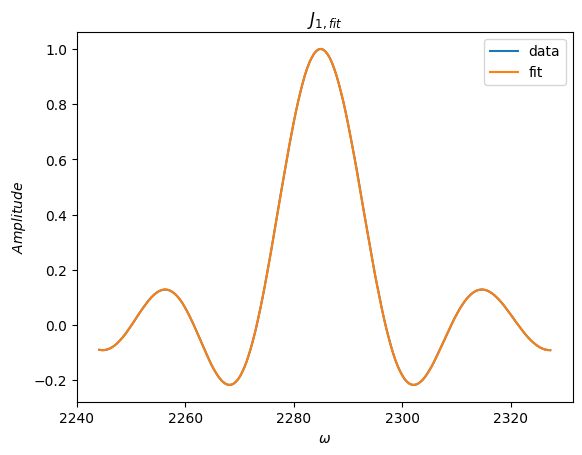

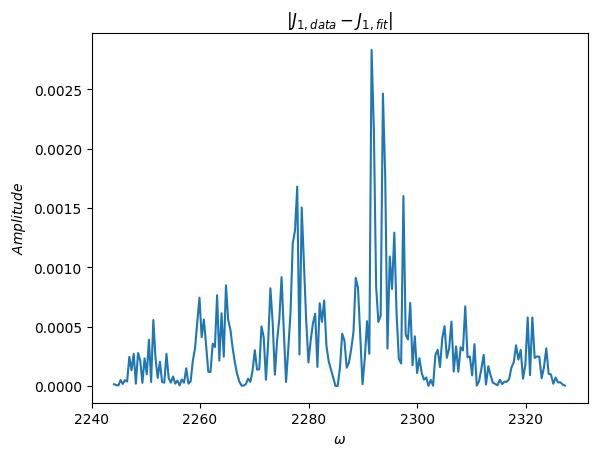

In [40]:
fig, ax1 = plt.subplots()
ax1.plot(ws, J1,label='data') 
ax1.plot(ws, J1_fit,label='fit') 
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$J_{1,fit}$")
ax1.legend()
plt.show()

fig, ax2 = plt.subplots()
ax2.plot(ws, np.abs(J1-J1_fit)) 
ax2.set_xlabel(r"$\omega$")
ax2.set_ylabel(r"$Amplitude$")
ax2.set_title(r"$|J_{1,data}-J_{1,fit}|$")
plt.show()

We next consider the $J_3$ and $K_3$ contribution.

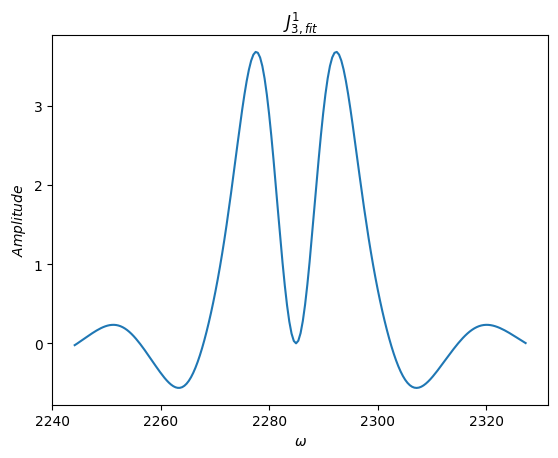

In [41]:
#First third order contribution
J3_fit = Magnus3CW_fit_Re(ws,wi,ks_poly,ki_poly,k_pol,p_k,L)

fig, ax3 = plt.subplots()
ax3.plot(ws, J3_fit)
ax3.set_xlabel(r"$\omega$")
ax3.set_ylabel(r"$Amplitude$")
ax3.set_title(r"$J_{3,fit}^1$")
plt.show()

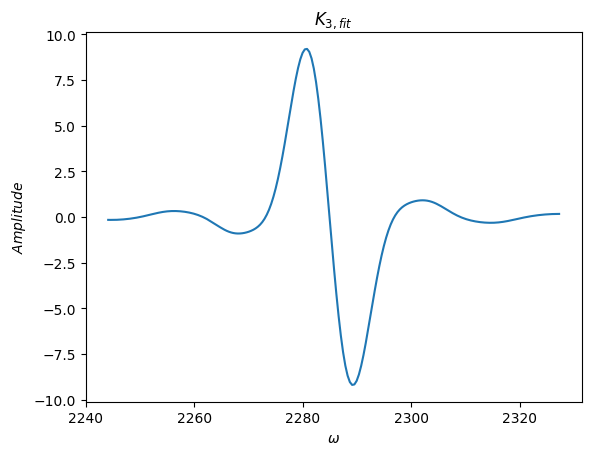

In [42]:
#K3 contrib
K3_fit = Magnus3CW_fit_Im(ws,wi,ks_poly,ki_poly,k_pol,p_k,L)

fig, ax1 = plt.subplots()
ax1.plot(ws, K3_fit)
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$K_{3,fit}$")
plt.show()

Combining everything together, looking at both |JSA| and Intensity. At this point it is also easy to compare both methods (need to plot previous results w.r.t. 'ws' instead of 'lambda_s').

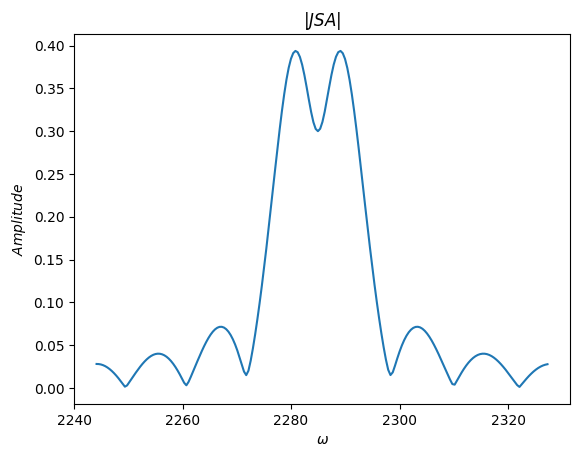

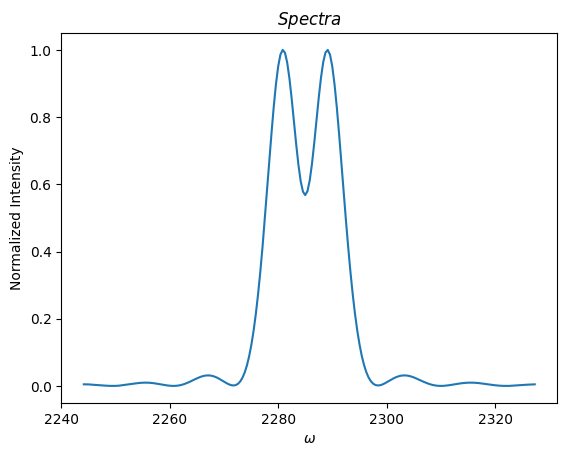

In [43]:
#Strength parameter for Magnus expansion
JSA_full_fit = lambda epsilon: epsilon*J1_fit+(epsilon**3)*(J3_fit -1j*K3_fit)

#Multiply by this phase if x0=0 is the start of the nonlinear region
Phase_fit = np.exp(1j*L*(ks_poly+ki_poly+k_pol-p_k)/2) 
epsilon = 0.3


fig, ax1 = plt.subplots()
ax1.plot(ws, np.abs(JSA_full_fit(epsilon)))
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$|JSA|$")
plt.show()

#Intensity
Intensity_fit = lambda epsilon: np.sinh(np.abs(JSA_full_fit(epsilon)))**2/np.amax(np.sinh(np.abs(JSA_full_fit(epsilon)))**2)

fig, ax2 = plt.subplots()
ax2.plot(ws, Intensity_fit(epsilon))
ax2.set_xlabel(r"$\omega$")
ax2.set_ylabel(r"Normalized Intensity")
ax2.set_title(r"$Spectra$")
plt.show()

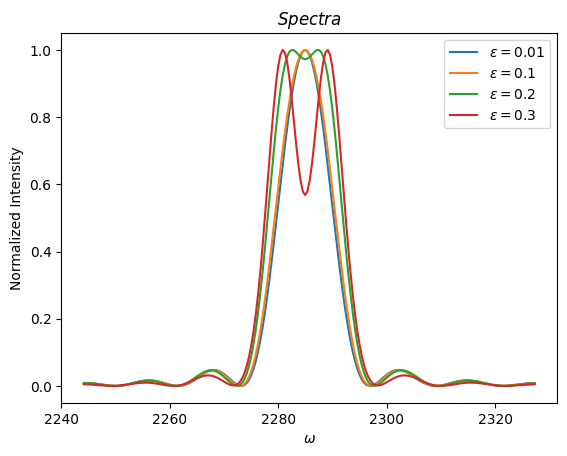

In [44]:
#Comparing for different values of interaction strength

fig, ax1 = plt.subplots()
ax1.plot(ws, Intensity_fit(0.01),label=r"$\epsilon=0.01$")
ax1.plot(ws, Intensity_fit(0.1),label=r"$\epsilon=0.1$")
ax1.plot(ws, Intensity_fit(0.2),label=r"$\epsilon=0.2$")
ax1.plot(ws, Intensity_fit(0.3),label=r"$\epsilon=0.3$")
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"Normalized Intensity")
ax1.set_title(r"$Spectra$")
ax1.legend()
plt.show()